In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
sys.path.insert(0, '../../python')
from measurements import *
from scipy.interpolate import interp1d

from scipy.optimize import fsolve

plotter = Plotter()

from fitv2 import *

import o4universalityclass as o4


import h5py



#processedDataDir = "../data/processedv4/"


#This is the path to were you saved the processed correlators.
processedDataDir = "/home/superpions/processed_data/unbroken_H0/"
processedDataDir = "../../python/"



gdir = '../../gnuplot_data/'


mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif')
mpl.rc('font', size = '14')

mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14) 

def ylabel(ax, label, fts = 14):
    ax.set_ylabel(label, fontsize=fts)
def xlabel(ax, label, fts = 14):
    ax.set_xlabel(label, fontsize=fts)       

#%load_ext gnuplot_kernel


dt=0.72
chi0 = 5.0


def getNameStr(m, v):
    res = "{}".format(m).split('.')
    mStr = "m-0" + res[0][1:] + res[1]
    while len(mStr)<9:
        mStr+='0'
    vStr = "{}".format(v)
    vStr = "N0" + vStr if v < 100 else "N" + vStr
    return "zeroHlongDiffuse_" + vStr + "_" + mStr + "_h000000_c00500"

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
sys.path.insert(0, '../../python')
from measurements import *
from scipy.interpolate import interp1d

from scipy.optimize import fsolve

plotter = Plotter()

from fitv2 import *

import o4universalityclass as o4


import h5py



#processedDataDir = "../data/processedv4/"


#This is the path to were you saved the processed correlators.
processedDataDir = "/home/superpions/processed_data/unbroken_H0/"
processedDataDir = "../../python/"



gdir = '../../gnuplot_data/'


mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif')
mpl.rc('font', size = '14')

mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14) 

def ylabel(ax, label, fts = 14):
    ax.set_ylabel(label, fontsize=fts)
def xlabel(ax, label, fts = 14):
    ax.set_xlabel(label, fontsize=fts)       

#%load_ext gnuplot_kernel


dt=0.72
chi0 = 5.0


def getNameStr(m, v):
    res = "{}".format(m).split('.')
    mStr = "m-0" + res[0][1:] + res[1]
    while len(mStr)<9:
        mStr+='0'
    vStr = "{}".format(v)
    vStr = "N0" + vStr if v < 100 else "N" + vStr
    return "zeroHlongDiffuse_" + vStr + "_" + mStr + "_h000000_c00500"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:




volumes = [96]#,48,64]


masses = dict()
masses[volumes[0]] = [-4.78000,-4.76000,-4.73366,-4.72800, -4.72000,-4.71000,-4.70052, -4.68000, -4.63000] 
#masses[volumes[0]] = [-4.73366,-4.72800, -4.72000,-4.71000,-4.70052, -4.68000, -4.63000] 
#masses[volumes[1]] = [-4.72000] 
#masses[volumes[2]] = [-4.72000] 

mc = -4.81100

reducedMasses = dict()
for v in volumes:
    reducedMasses[v] = (mc - np.asarray(masses[v])) / mc


data=dict()
dataFn=dict()


for v in volumes:
    dataFn[v] = dict()
    data[v] = dict()

nk=5

keys = []
for k in range(1,nk+1):
    keys.append("Vkk{}".format(k))
    keys.append("Akk{}".format(k))

moms = dict()
moms_l = []
for p in range(1,nk+1):
    moms_l.append(2.0*(1.0-np.cos(2.0* np.pi * p / volumes[0])))
    moms["Akk{}".format(p)] = 2.0*(1.0-np.cos(2.0* np.pi * p / volumes[0])) #np.sin(2.0* np.pi * p / volumes[0])
    moms["Vkk{}".format(p)] = 2.0*(1.0-np.cos(2.0* np.pi * p / volumes[0])) #np.sin(2.0* np.pi * p / volumes[0])

In [4]:
fitter = dict()

for v in volumes:
    for m in masses[v]:
        dataFn[v][m] = getNameStr(m, v)
        data[v][m] = ConfResults(fn="../../run_H0/" + dataFn[v][m] + "/" + dataFn[v][m] + ".h5" ,thTime=5000,dt=dt, data_format="new", processedDir=processedDataDir, plotDir=gdir,loadFourierBool = True)

In [5]:
for v in volumes:
    for m in masses[v]:
        for k in keys:
            data[v][m].load("OtOttp",k, direc=processedDataDir)
            data[v][m].load("OtOttp_blocks",k, direc=processedDataDir)
        #data[v][m].load("OtOttpRatio",key, direc=processedDataDir)
        #data[v][m].load("OtOttpRatio_blocks",key, direc=processedDataDir)

# Integral

In [6]:
def autocorrelationTime(data, dt, moms,indMax = -1 ,keys = keys):
    tauBlocks = []
    for key in keys:
        for b in data.OtOttp_blocks[key]:
            tauBlocks.append(1.0/(np.sum(b[:indMax[key]]) * dt / b[0]) * 1.0/moms[key])
    return np.mean(tauBlocks), sps.sem(tauBlocks)

In [7]:
autoCor = dict()
autoCorErr = dict()
autoCorK = dict()
autoCorErrK = dict()
autoCorTMax = dict()

for v in volumes:
    autoCor[v] = np.zeros(len(masses[v]))
    autoCorErr[v] = np.zeros(len(masses[v]))
    autoCorK[v] = dict()
    autoCorErrK[v] = dict()
    autoCorTMax[v] = dict()
    for m in masses[v]:
        autoCorTMax[v][m] = dict()

    for key in range(1,nk+1):
        autoCorK[v][key] = np.zeros(len(masses[v]))
        autoCorErrK[v][key] = np.zeros(len(masses[v]))


In [8]:
autoCorTMax[volumes[0]][masses[volumes[0]][0]]["Vkk1"]  = 4300
autoCorTMax[volumes[0]][masses[volumes[0]][1]]["Vkk1"]  = 4300
autoCorTMax[volumes[0]][masses[volumes[0]][2]]["Vkk1"]  = 4300
autoCorTMax[volumes[0]][masses[volumes[0]][3]]["Vkk1"]  = 4300
autoCorTMax[volumes[0]][masses[volumes[0]][4]]["Vkk1"]  = 4300
autoCorTMax[volumes[0]][masses[volumes[0]][5]]["Vkk1"]  = 4300
autoCorTMax[volumes[0]][masses[volumes[0]][6]]["Vkk1"]  = 4600
autoCorTMax[volumes[0]][masses[volumes[0]][7]]["Vkk1"]  = 4300
autoCorTMax[volumes[0]][masses[volumes[0]][8]]["Vkk1"]  = 4300


autoCorTMax[volumes[0]][masses[volumes[0]][0]]["Akk1"] = 4300
autoCorTMax[volumes[0]][masses[volumes[0]][1]]["Akk1"]  = 4300
autoCorTMax[volumes[0]][masses[volumes[0]][2]]["Akk1"]  = 4300
autoCorTMax[volumes[0]][masses[volumes[0]][3]]["Akk1"]  = 4300
autoCorTMax[volumes[0]][masses[volumes[0]][4]]["Akk1"]  = 4300
autoCorTMax[volumes[0]][masses[volumes[0]][5]]["Akk1"]  = 4300
autoCorTMax[volumes[0]][masses[volumes[0]][6]]["Akk1"]  = 4600
autoCorTMax[volumes[0]][masses[volumes[0]][7]]["Akk1"]  = 4300
autoCorTMax[volumes[0]][masses[volumes[0]][8]]["Akk1"]  = 4300

autoCorTMax[volumes[0]][masses[volumes[0]][0]]["Vkk2"]  = 1300
autoCorTMax[volumes[0]][masses[volumes[0]][1]]["Vkk2"]  = 1300
autoCorTMax[volumes[0]][masses[volumes[0]][2]]["Vkk2"]  = 1300
autoCorTMax[volumes[0]][masses[volumes[0]][3]]["Vkk2"]  = 1300
autoCorTMax[volumes[0]][masses[volumes[0]][4]]["Vkk2"]  = 1300
autoCorTMax[volumes[0]][masses[volumes[0]][5]]["Vkk2"]  = 1300
autoCorTMax[volumes[0]][masses[volumes[0]][6]]["Vkk2"]  = 1600
autoCorTMax[volumes[0]][masses[volumes[0]][7]]["Vkk2"]  = 1300
autoCorTMax[volumes[0]][masses[volumes[0]][8]]["Vkk2"]  = 1300


autoCorTMax[volumes[0]][masses[volumes[0]][0]]["Akk2"] =  1300
autoCorTMax[volumes[0]][masses[volumes[0]][1]]["Akk2"]  = 1300
autoCorTMax[volumes[0]][masses[volumes[0]][2]]["Akk2"]  = 1300
autoCorTMax[volumes[0]][masses[volumes[0]][3]]["Akk2"]  = 1300
autoCorTMax[volumes[0]][masses[volumes[0]][4]]["Akk2"]  = 1300
autoCorTMax[volumes[0]][masses[volumes[0]][5]]["Akk2"]  = 1300
autoCorTMax[volumes[0]][masses[volumes[0]][6]]["Akk2"]  = 1600
autoCorTMax[volumes[0]][masses[volumes[0]][7]]["Akk2"]  = 1600
autoCorTMax[volumes[0]][masses[volumes[0]][8]]["Akk2"]  = 1600

autoCorTMax[volumes[0]][masses[volumes[0]][0]]["Vkk3"]  = 600
autoCorTMax[volumes[0]][masses[volumes[0]][1]]["Vkk3"]  = 600
autoCorTMax[volumes[0]][masses[volumes[0]][2]]["Vkk3"]  = 600
autoCorTMax[volumes[0]][masses[volumes[0]][3]]["Vkk3"]  = 600
autoCorTMax[volumes[0]][masses[volumes[0]][4]]["Vkk3"]  = 600
autoCorTMax[volumes[0]][masses[volumes[0]][5]]["Vkk3"]  = 600
autoCorTMax[volumes[0]][masses[volumes[0]][6]]["Vkk3"]  = 600
autoCorTMax[volumes[0]][masses[volumes[0]][7]]["Vkk3"]  = 600
autoCorTMax[volumes[0]][masses[volumes[0]][8]]["Vkk3"]  = 600


autoCorTMax[volumes[0]][masses[volumes[0]][0]]["Akk3"] =  600
autoCorTMax[volumes[0]][masses[volumes[0]][1]]["Akk3"]  = 600
autoCorTMax[volumes[0]][masses[volumes[0]][2]]["Akk3"]  = 600
autoCorTMax[volumes[0]][masses[volumes[0]][3]]["Akk3"]  = 600
autoCorTMax[volumes[0]][masses[volumes[0]][4]]["Akk3"]  = 600
autoCorTMax[volumes[0]][masses[volumes[0]][5]]["Akk3"]  = 600
autoCorTMax[volumes[0]][masses[volumes[0]][6]]["Akk3"]  = 600
autoCorTMax[volumes[0]][masses[volumes[0]][7]]["Akk3"]  = 600
autoCorTMax[volumes[0]][masses[volumes[0]][8]]["Akk3"]  = 600


autoCorTMax[volumes[0]][masses[volumes[0]][0]]["Vkk4"]  = 400
autoCorTMax[volumes[0]][masses[volumes[0]][1]]["Vkk4"]  = 400
autoCorTMax[volumes[0]][masses[volumes[0]][2]]["Vkk4"]  = 400
autoCorTMax[volumes[0]][masses[volumes[0]][3]]["Vkk4"]  = 400
autoCorTMax[volumes[0]][masses[volumes[0]][4]]["Vkk4"]  = 400
autoCorTMax[volumes[0]][masses[volumes[0]][5]]["Vkk4"]  = 400
autoCorTMax[volumes[0]][masses[volumes[0]][6]]["Vkk4"]  = 400
autoCorTMax[volumes[0]][masses[volumes[0]][7]]["Vkk4"]  = 400
autoCorTMax[volumes[0]][masses[volumes[0]][8]]["Vkk4"]  = 400


autoCorTMax[volumes[0]][masses[volumes[0]][0]]["Akk4"] =  400
autoCorTMax[volumes[0]][masses[volumes[0]][1]]["Akk4"]  = 400
autoCorTMax[volumes[0]][masses[volumes[0]][2]]["Akk4"]  = 400
autoCorTMax[volumes[0]][masses[volumes[0]][3]]["Akk4"]  = 400
autoCorTMax[volumes[0]][masses[volumes[0]][4]]["Akk4"]  = 400
autoCorTMax[volumes[0]][masses[volumes[0]][5]]["Akk4"]  = 400
autoCorTMax[volumes[0]][masses[volumes[0]][6]]["Akk4"]  = 400
autoCorTMax[volumes[0]][masses[volumes[0]][7]]["Akk4"]  = 400
autoCorTMax[volumes[0]][masses[volumes[0]][8]]["Akk4"]  = 400


autoCorTMax[volumes[0]][masses[volumes[0]][0]]["Vkk5"]  = 400
autoCorTMax[volumes[0]][masses[volumes[0]][1]]["Vkk5"]  = 400
autoCorTMax[volumes[0]][masses[volumes[0]][2]]["Vkk5"]  = 400
autoCorTMax[volumes[0]][masses[volumes[0]][3]]["Vkk5"]  = 400
autoCorTMax[volumes[0]][masses[volumes[0]][4]]["Vkk5"]  = 400
autoCorTMax[volumes[0]][masses[volumes[0]][5]]["Vkk5"]  = 400
autoCorTMax[volumes[0]][masses[volumes[0]][6]]["Vkk5"]  = 400
autoCorTMax[volumes[0]][masses[volumes[0]][7]]["Vkk5"]  = 400
autoCorTMax[volumes[0]][masses[volumes[0]][8]]["Vkk5"]  = 400


autoCorTMax[volumes[0]][masses[volumes[0]][0]]["Akk5"] =  400
autoCorTMax[volumes[0]][masses[volumes[0]][1]]["Akk5"]  = 400
autoCorTMax[volumes[0]][masses[volumes[0]][2]]["Akk5"]  = 400
autoCorTMax[volumes[0]][masses[volumes[0]][3]]["Akk5"]  = 400
autoCorTMax[volumes[0]][masses[volumes[0]][4]]["Akk5"]  = 400
autoCorTMax[volumes[0]][masses[volumes[0]][5]]["Akk5"]  = 400
autoCorTMax[volumes[0]][masses[volumes[0]][6]]["Akk5"]  = 400
autoCorTMax[volumes[0]][masses[volumes[0]][7]]["Akk5"]  = 400
autoCorTMax[volumes[0]][masses[volumes[0]][8]]["Akk5"]  = 400

/tmp/ipykernel_1602508/2331928954.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(c)


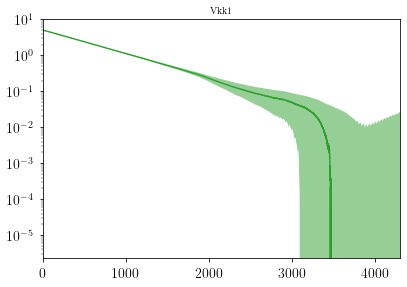

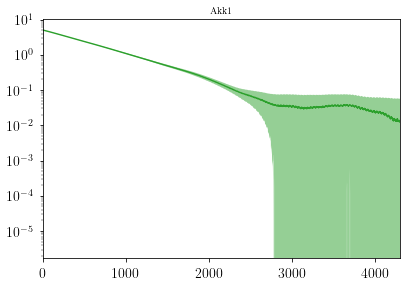

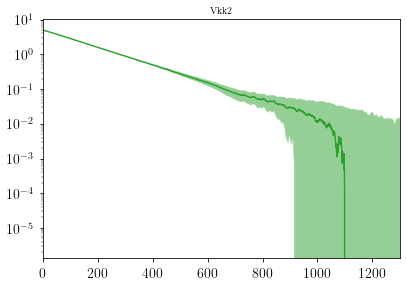

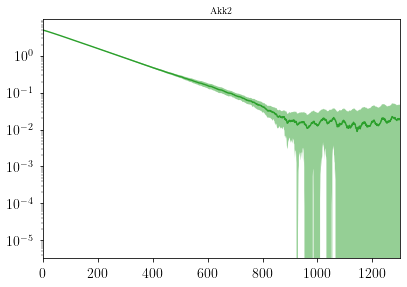

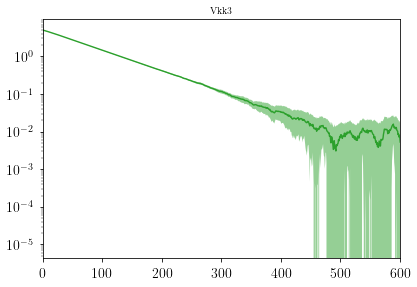

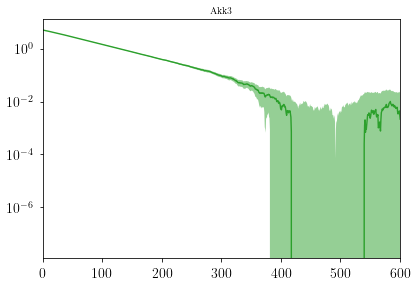

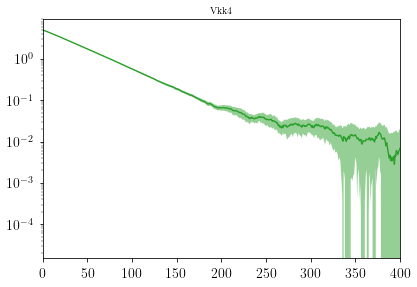

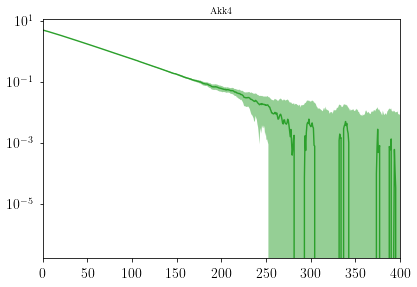

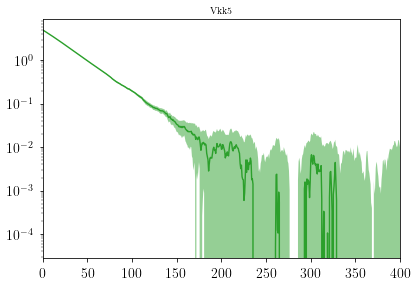

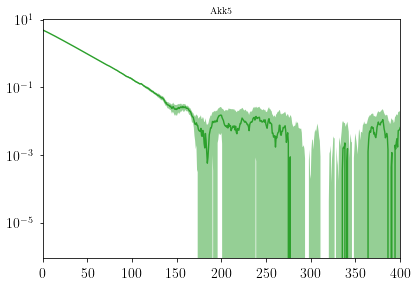

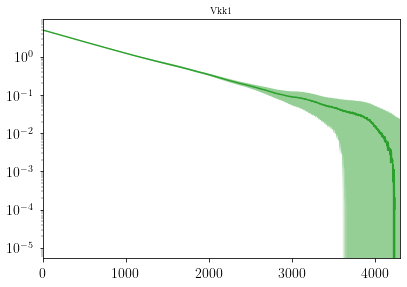

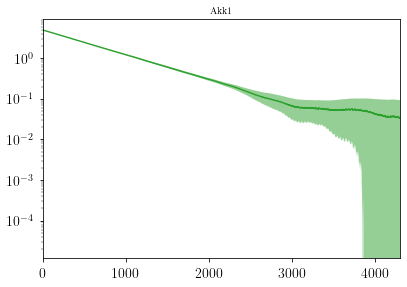

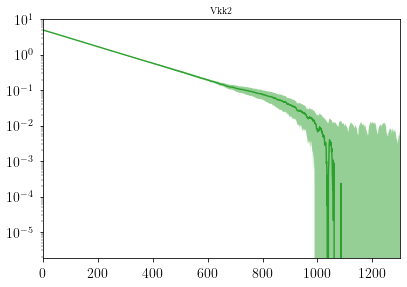

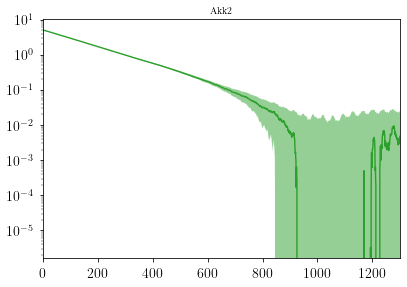

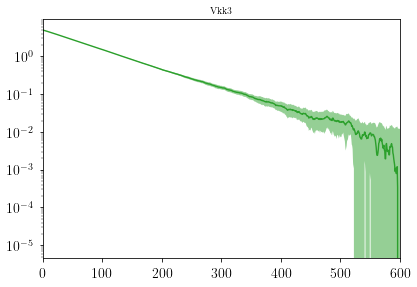

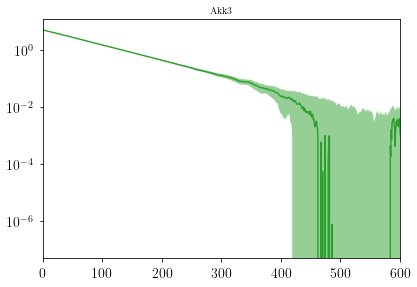

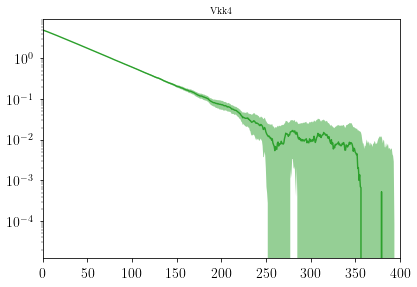

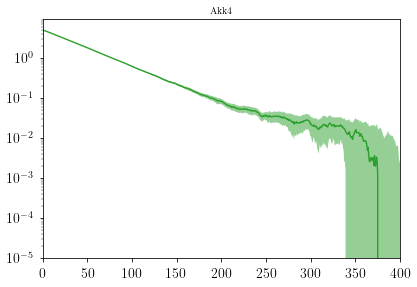

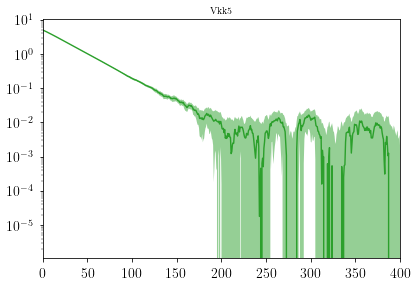

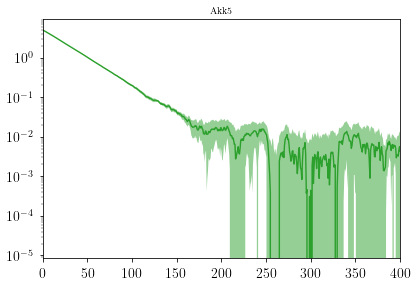

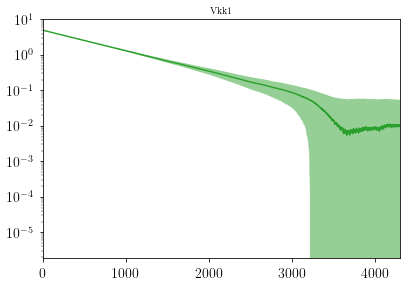

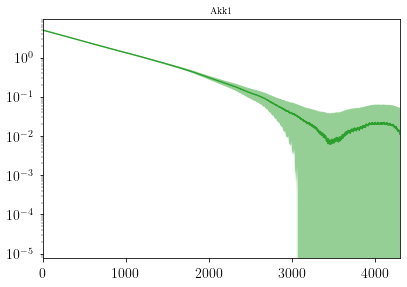

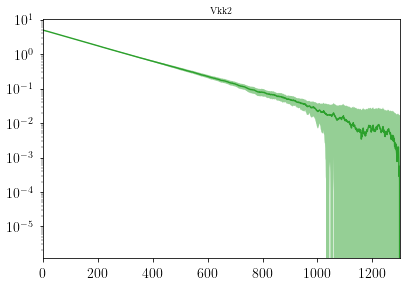

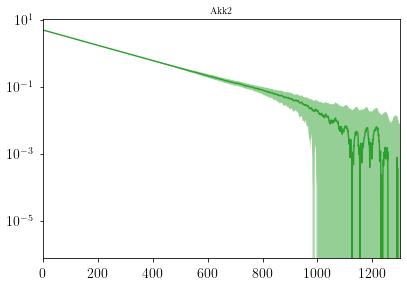

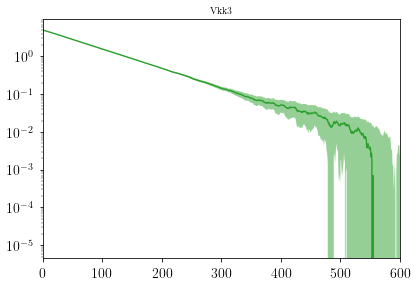

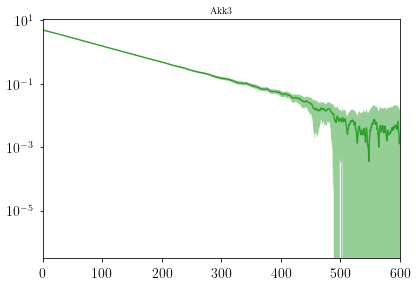

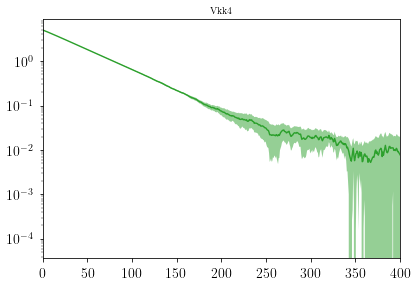

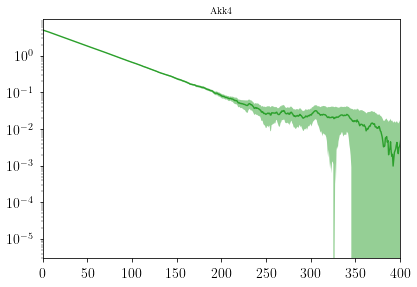

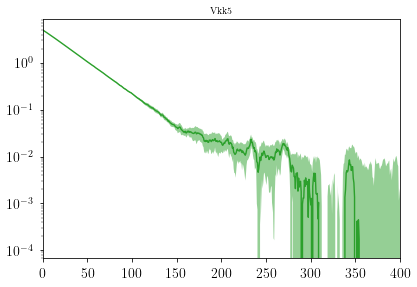

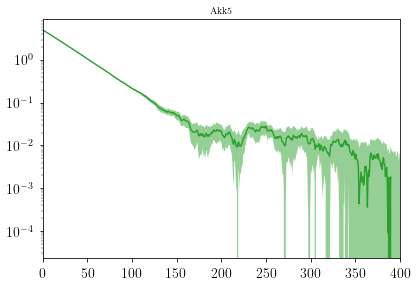

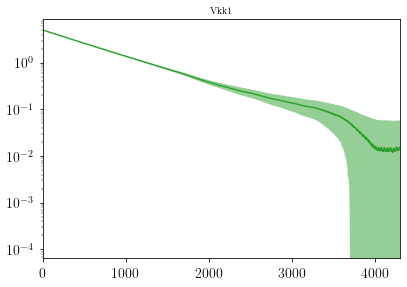

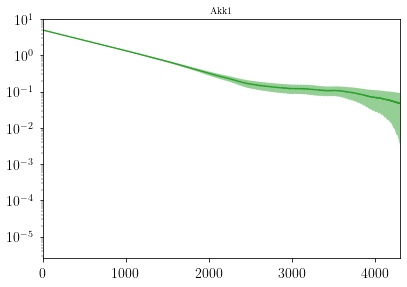

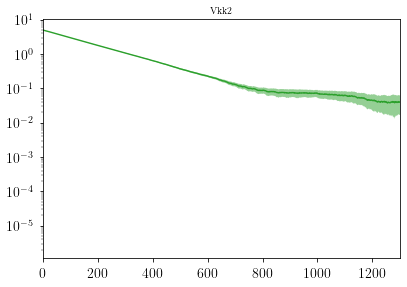

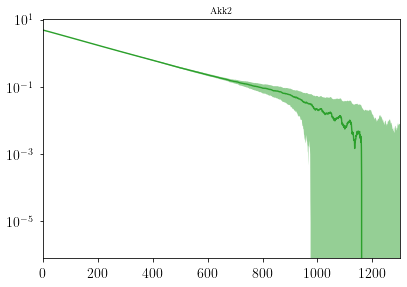

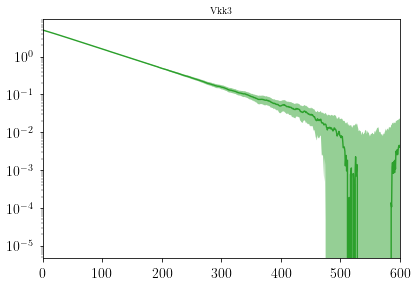

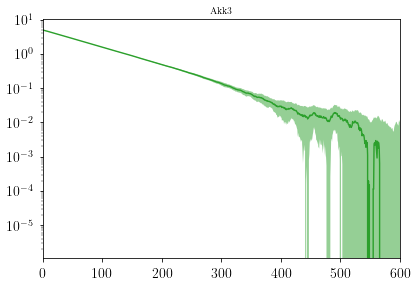

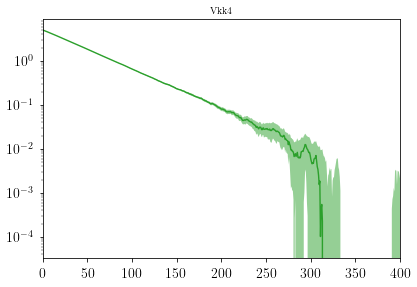

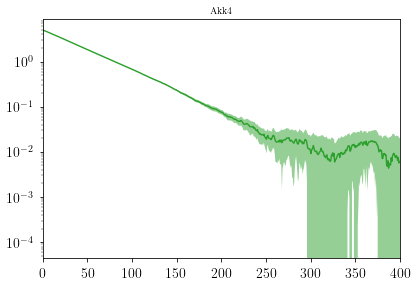

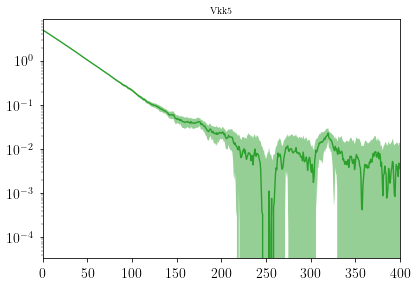

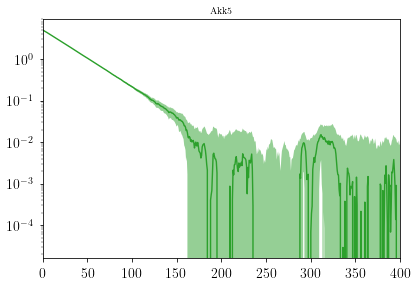

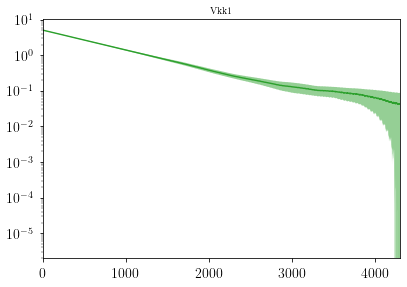

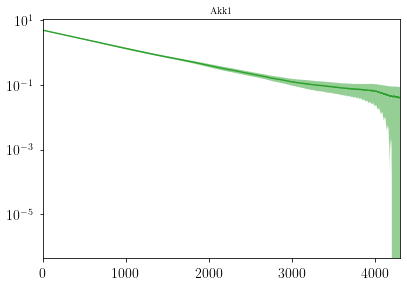

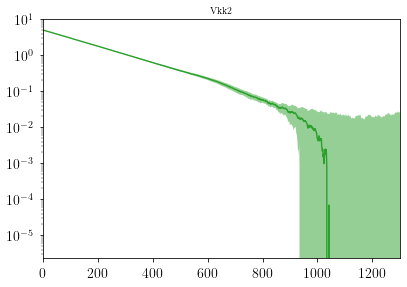

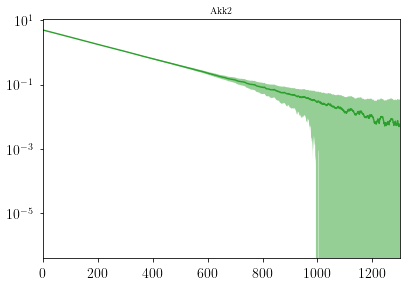

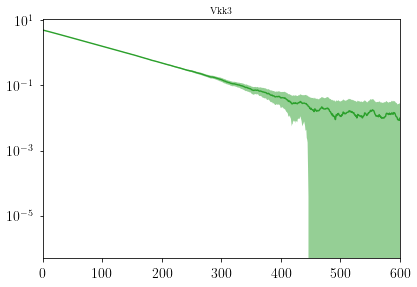

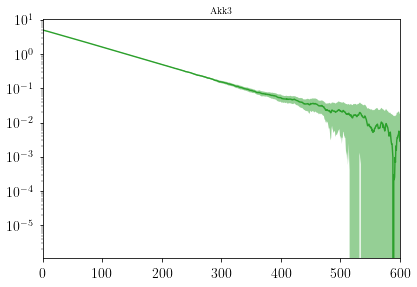

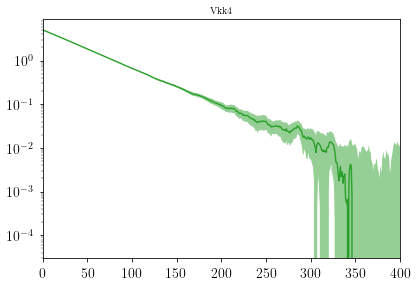

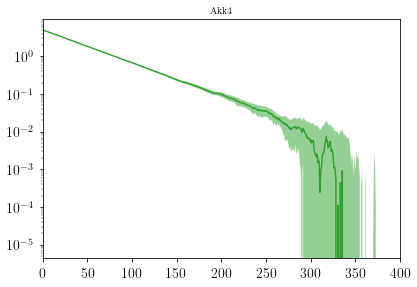

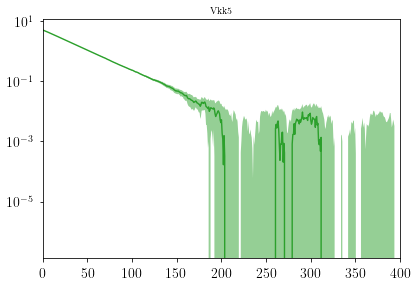

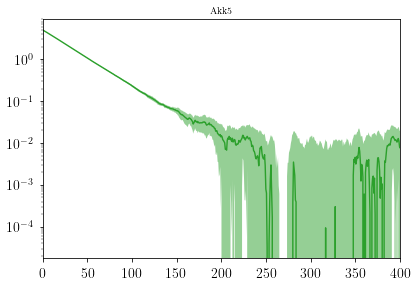

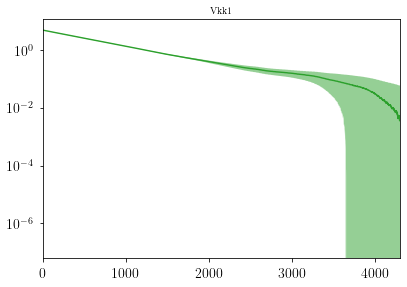

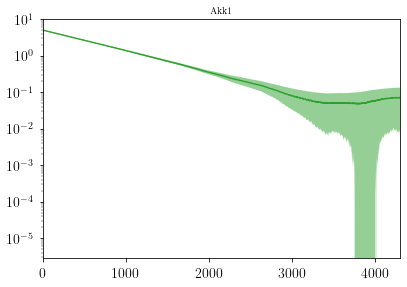

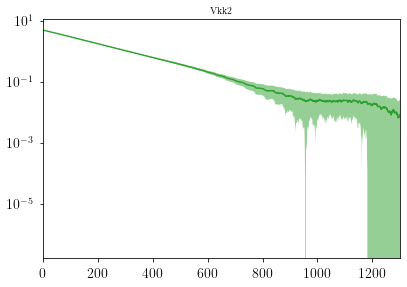

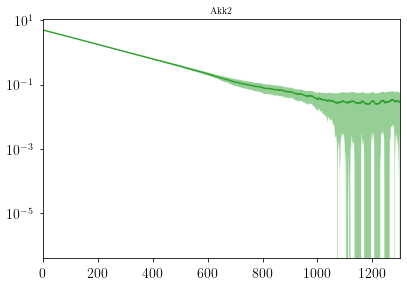

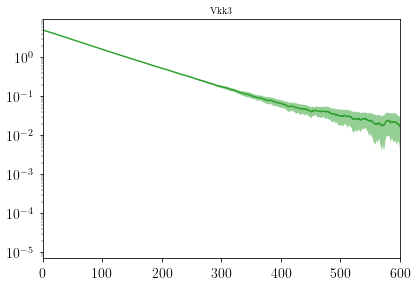

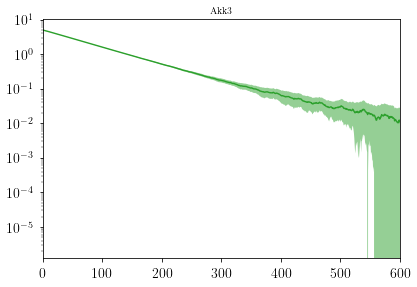

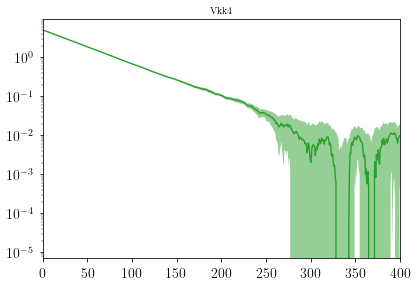

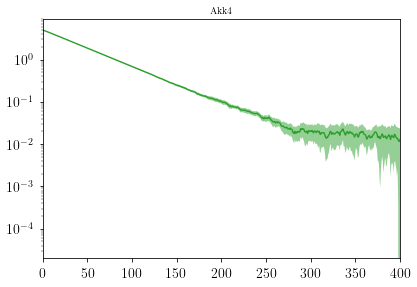

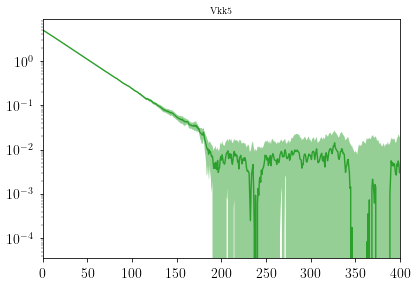

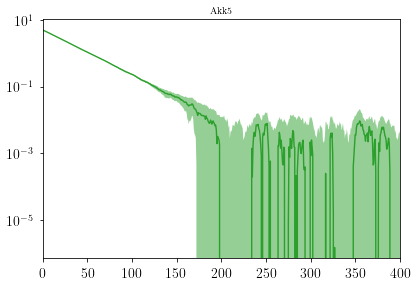

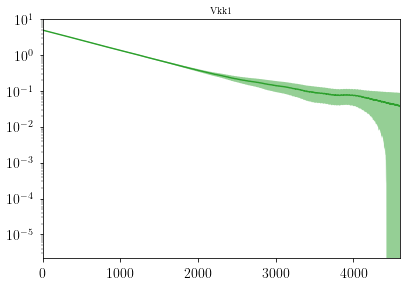

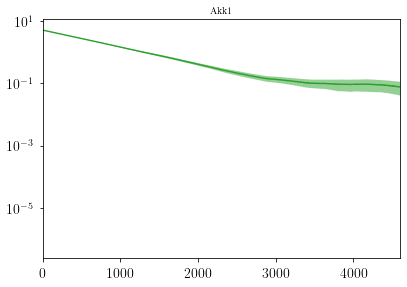

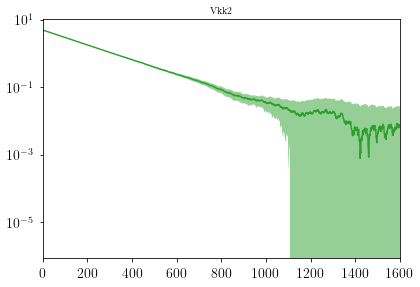

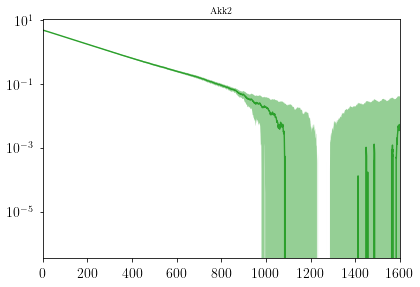

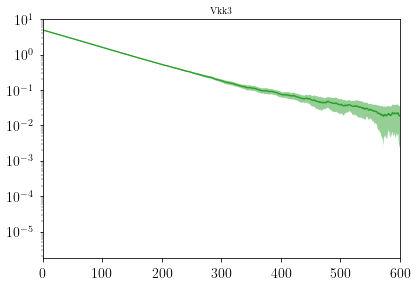

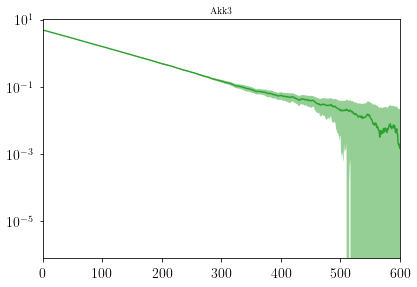

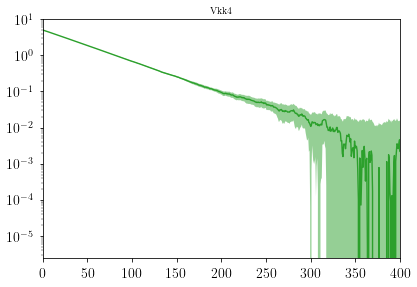

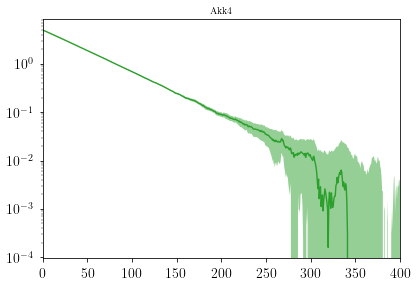

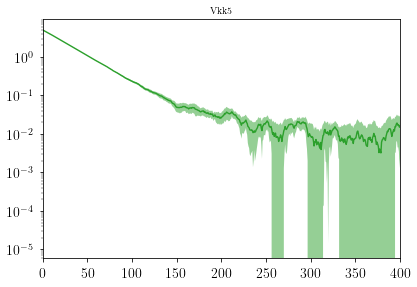

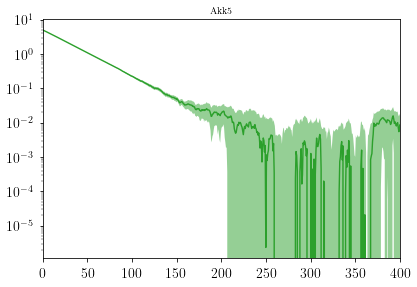

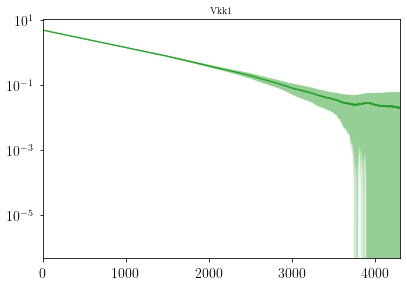

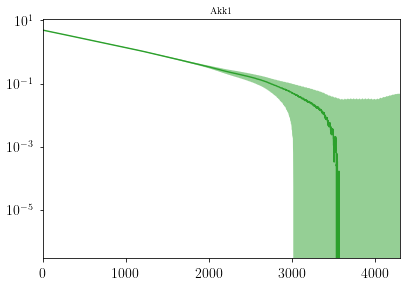

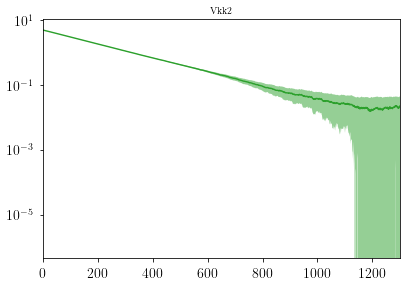

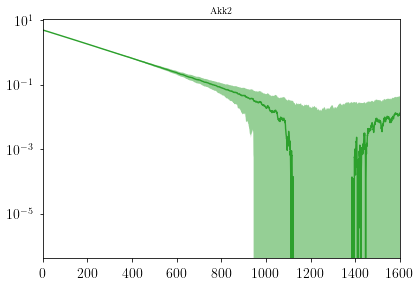

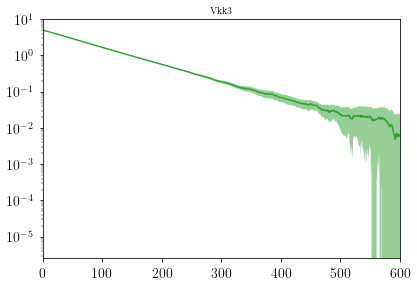

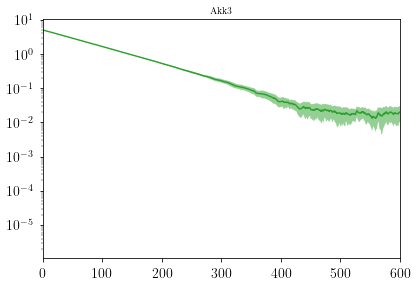

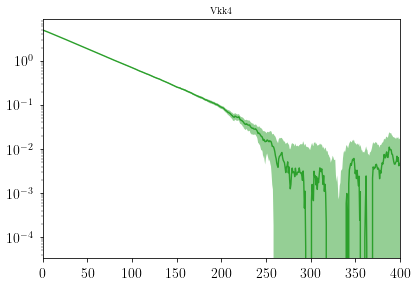

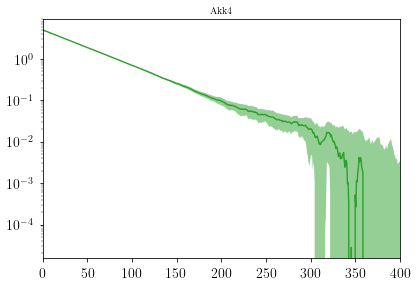

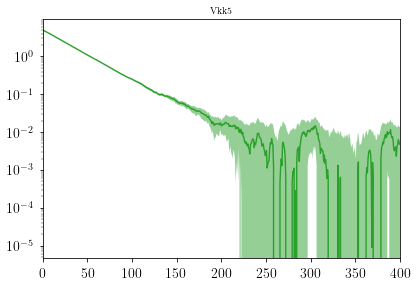

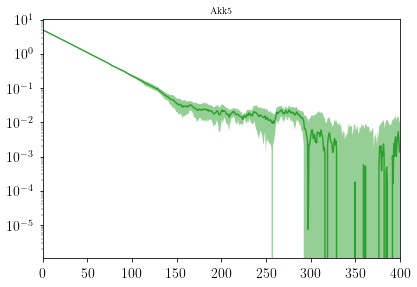

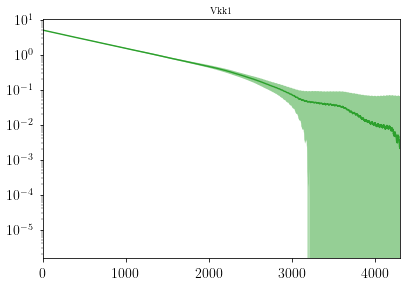

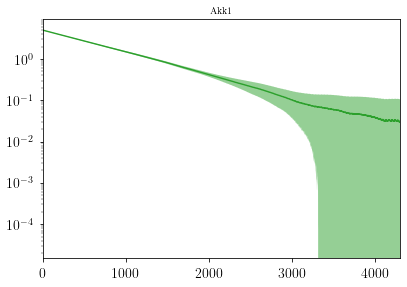

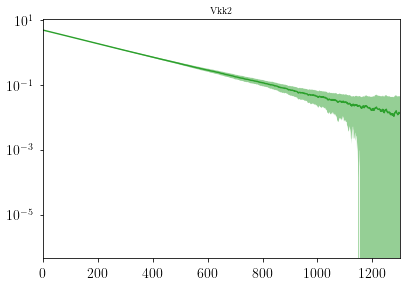

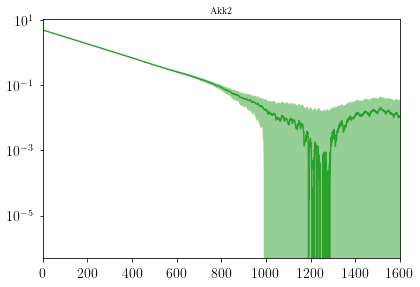

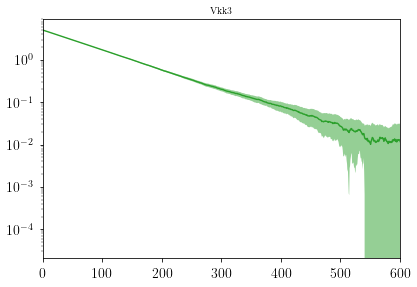

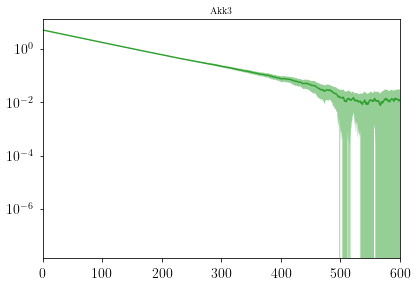

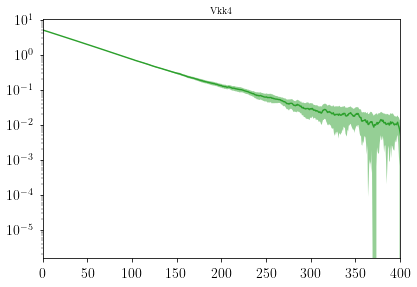

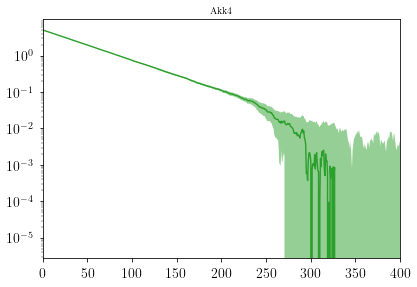

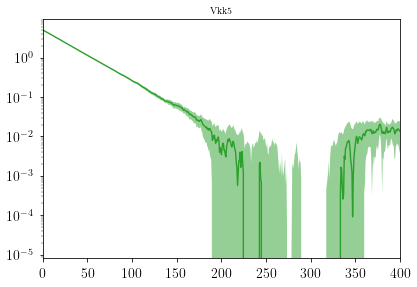

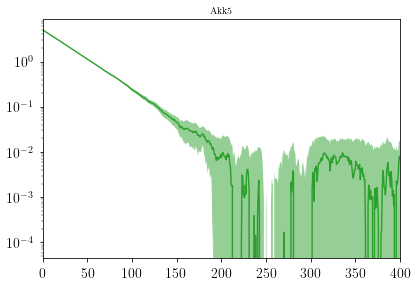

In [24]:
c=0
for v in volumes:
    for m in masses[v]:
        for key in keys:
            plt.figure(c)
            plotter.plot(data[v][m],"OtOttp", key)
            plt.xlim(0,autoCorTMax[v][m][key])
            c+=1
            plt.yscale('log')
            plt.title(key)


In [9]:
for v in volumes:
    c = 0
    k1 = 2.0* np.pi  / v
    for m in masses[v]:
        autoCor[v][c], autoCorErr[v][c] = autocorrelationTime(data[v][m], 0.72, moms, autoCorTMax[v][m], keys= keys)
        for key in range(1,nk+1):
            autoCorK[v][key][c], autoCorErrK[v][key][c] = autocorrelationTime(data[v][m], 0.72, moms, autoCorTMax[v][m], keys= ["Akk{}".format(key), "Vkk{}".format(key)])
        c+=1

/tmp/ipykernel_1605871/2968760170.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  autoCor[v][c], autoCorErr[v][c] = autocorrelationTime(data[v][m], 0.72, moms, autoCorTMax[v][m], keys= keys)
/tmp/ipykernel_1605871/2968760170.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  autoCorK[v][key][c], autoCorErrK[v][key][c] = autocorrelationTime(data[v][m], 0.72, moms, autoCorTMax[v][m], keys= ["Akk{}".format(key), "Vkk{}".format(key)])


In [10]:
v = volumes[0]


scaling = lambda x, par : par[0] * x**(-o4.nu*0.5) * (1.0 + par[1] * x**(o4.omega*o4.nu)) + 0.2425#(1.0 + par[1] * x**(o4.omega*o4.nu)
#scaling = lambda x, par : par[0] * x**(-o4.nu*0.5)  + par[1]#(1.0 + par[1] * x**(o4.omega*o4.nu)


chi2 = lambda par : np.sum(np.square((autoCorK[v][1] - scaling(reducedMasses[v], par)) / autoCorErrK[v][1] ))
fit2nd = Minuit(chi2, [0.002, 0.33], name=["xim1", "xim1+"])

fit2nd.errordef = Minuit.LEAST_SQUARES

fit2nd.limits = [(0,20.0),(-10,10.5)]

fit2nd.migrad()
fit2nd.minos();

In [11]:
fit2nd

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 5.651                      │              Nfcn = 144              │
│ EDM = 2.26e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ xim1  │  0.0191   │  0.0013   │  -0.0013   │   0.0013   │    0    │   20    │       │
│ 1 │ xim1+ │   -1.7    │    0.6    │    -0.5    │    0.6     │   -10   │  10.5   │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┐
│          │         xim1          │         xim1+         │
├──────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │  -0.0013  │  0.0013   │   -0.5    │    0.6    │
│  Valid   │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┘
┌───────┬─────────────────────┐
│       │      xim1     xim1+ │
├───────┼─────────────────────┤
│  xim1 │  1.74e-06 -0.000688 │
│ xim1+ │ -0.000688     0.304 │
└───────┴─────────────────────┘

In [29]:
1/3.0 * 0.8

0.26666666666666666

In [60]:
fit2nd.fval / (len(masses[volumes[0]]) - 2)

0.8073358426570961

<ErrorbarContainer object of 3 artists>

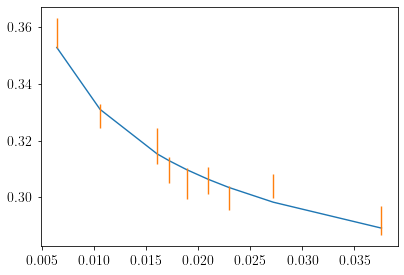

In [12]:
v = volumes[0]


plt.plot(reducedMasses[v],scaling(reducedMasses[v],fit2nd.values))
plt.errorbar(reducedMasses[v], autoCorK[v][1], autoCorErrK[v][1], ls='None')
#plt.yscale('log')
#plt.xscale('log')

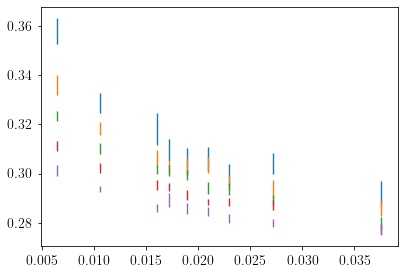

In [29]:
for k in range(1,nk+1):
    plt.errorbar(reducedMasses[v], autoCorK[v][k], autoCorErrK[v][k], ls='None')

<ErrorbarContainer object of 3 artists>

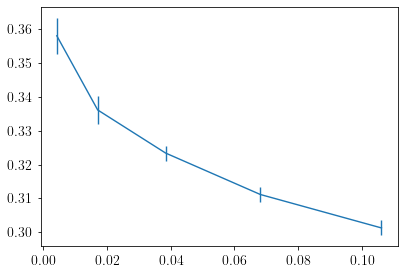

In [25]:
v = volumes[0]
m = 0

tmp = []
tmpErr = []

for k in range(1,nk+1):
    tmp.append(autoCorK[v][k][m])
    tmpErr.append(autoCorErrK[v][k][m])

plt.errorbar(moms_l, tmp, tmpErr)
#plt.yscale('log')
#plt.xscale('log')

In [31]:
v = volumes[0]


correc = lambda x, par : par[0] + par[1] *x + par[2] *x**2#(1.0 + par[1] * x**(o4.omega*o4.nu)
#scaling = lambda x, par : par[0] * x**(-o4.nu*0.5)  + par[1]#(1.0 + par[1] * x**(o4.omega*o4.nu)


chi2 = lambda par : np.sum(np.square((tmp - correc(np.asarray(moms_l), par)) / tmpErr ))
fitk = Minuit(chi2, [0.002, 0.33,0.4], name=["xim1", "xim1+","xim"])

fitk.errordef = Minuit.LEAST_SQUARES

fitk.limits = [(0,20.0),(-10,10.5),(-10,10.5)]

fitk.migrad()
fitk.minos();

In [32]:
moms_l

[0.004282153522793042,
 0.01711027725237968,
 0.03842943919353914,
 0.06814834742186315,
 0.10613974100978862]

In [33]:
fitk

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.45                       │              Nfcn = 265              │
│ EDM = 4.17e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ xim1  │   0.355   │   0.004   │   -0.004   │   0.004    │    0    │   20    │       │
│ 1 │ xim1+ │   -0.97   │   0.16    │   -0.16    │    0.16    │   -10   │  10.5   │       │
│ 2 │ xim   │    4.4    │    1.2    │    -1.2    │    1.2     │   -10   │  10.5   │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │         xim1          │         xim1+         │          xim          │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │  -0.004   │   0.004   │   -0.16   │   0.16    │   -1.2    │    1.2    │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌───────┬───────────────────────────────┐
│       │      xim1     xim1+       xim │
├───────┼───────────────────────────────┤
│  xim1 │  1.91e-05 -0.000622   0.00427 │
│ xim1+ │ -0.000622    0.0245    -0.184 │
│   xim │   0.00427    -0.184      1.46 │
└───────┴───────────────────────────────┘

### Plots

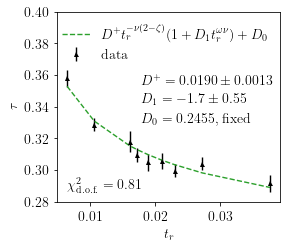

In [57]:
v = volumes[0]
plt.figure(0)
ax = plt.gca()

ax.errorbar(reducedMasses[v], autoCorK[v][1], autoCorErrK[v][1], ls='None', marker='^', color='k',label='data',markersize=5)
ax.plot(reducedMasses[v],scaling(reducedMasses[v],fit2nd.values), ls = '--', color='tab:green',  label="$D^+t_r^{-\\nu(2-\zeta)}(1+D_1t_r^{\\omega\\nu})+D_0$")
#ax.set_yscale('log')
#ax.set_xscale('log')


ax.legend(prop={'size': 14}, frameon=False, framealpha=0.1, loc=1)

ax.set_ylabel("$\\tau$", fontsize=14)
ax.set_xlabel("$t_r$", fontsize=14)

ax.set_ylim(0.28,0.4)

#ax.yaxis.set_label_coords(-0.1,0.4)

ax.text(0.0178,0.355,"$D^+={:1.2}0\pm {:0.2}$".format(fit2nd.values[0], fit2nd.errors[0]))
ax.text(0.0178,0.3425,"$D_1={:1.3}\pm {:0.2}$".format(fit2nd.values[1], fit2nd.errors[1]))
ax.text(0.0178,0.33,"$D_0=0.2455$, fixed")
ax.text(6.5e-3,0.288,"$\chi^2_{}={:1.2}$".format("\mathrm{d.o.f.}",fit2nd.fval / (len(masses[v]) - 2)))
#ax.text(7e-3,60,"$C^+=0.449(5)$")

plt.gcf().set_size_inches(4.,3.5)

#ax.set_xticks([6e-3, 1e-2, 2e-2, 4e-2])

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) 

#ax.set_title("Correlation time", fontsize=14)

plt.savefig("restored_D.pdf", bbox_inches = "tight")

# 1/e

In [ ]:
def getDecayTime(data, key, nFolds):
    x,y = data.getObs("OtOttp", key)
    f = interp1d(x,y.mean / y.mean[0])
    fErrP = interp1d(x,(y.mean + y.err) / (y.mean[0] + y.err[0]))
    fErrM = interp1d(x,(y.mean - y.err) / (y.mean[0] - y.err[0]))
    res = fsolve(lambda x : np.real(f(x)) - 1.0 / np.exp(nFolds), 10.0)
    err1 = fsolve(lambda x : np.real(fErrP(x)) - 1.0 / np.exp(nFolds), 10.0)
    err2 = fsolve(lambda x : np.real(fErrM(x)) - 1.0 / np.exp(nFolds), 10.0)
    err = max(abs(err1-res), abs(res - err2))
    return res[0]/nFolds, err[0]/nFolds


In [ ]:
effMassesBis = dict()
effMassesErrBis = dict()

for v in volumes:
    effMassesBis[v] = np.zeros(len(masses[v]))
    effMassesErrBis[v] = np.zeros(len(masses[v]))
for v in volumes:
    count = 0
    for m in masses[v]:
        effMassesBis[v][count], effMassesErrBis[v][count] = getDecayTime(data[v][m], key,1)
        count += 1

/home/adrienflorio/.local/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


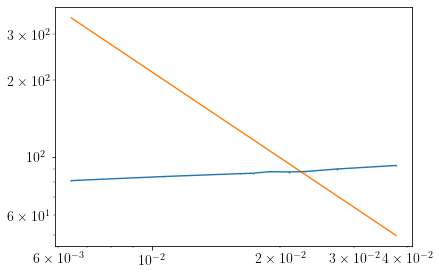

In [ ]:
for v in volumes:
    plt.errorbar(reducedMasses[v][:], effMassesBis[v][:], effMassesErrBis[v][:])
plt.yscale('log')
plt.xscale('log')
plt.plot(reducedMasses[volumes[0]][:],1.36*reducedMasses[volumes[0]][:]**(-1.098) )


In [ ]:
reducedMasses

{96: array([0.00644357, 0.01060071, 0.01607566, 0.01725213, 0.01891499,
        0.02099356, 0.02296404, 0.02722927, 0.03762212])}

In [56]:
moms_l

[0.004282153522793042,
 0.01711027725237968,
 0.03842943919353914,
 0.06814834742186315,
 0.10613974100978862]

In [ ]:
o4.nu * o4.omega

0.5569635000000001